In [1]:
import nltk
import numpy as np
import pandas as pd
from konlpy.tag import Mecab
from konlpy.tag import Okt
from konlpy.tag import Komoran
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from keras.models import load_model
from tqdm import tqdm
from tqdm import tqdm_notebook
from gensim import corpora
from gensim import models
from time import time
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore') 


mecab = Mecab()
okt = Okt()
komoran=Komoran()
hannanum=Hannanum()
kkma=Kkma()

# 데이터 불러오기

In [2]:
df = pd.read_excel('/Users/hyunkyungwoo/Documents/DABA4기 프로젝트/(공유) 더샵약국몰_상담내역_2019.04-06.xlsx')
#(공유) 더샵약국몰_상담내역_2019.04-06.xlsx
#(공유) 더샵약국몰_상담내역_2019.07-12.xlsx
#(공유) 더샵약국몰_상담내역_2020.01-06.xlsx
#(공유) 더샵약국몰_상담내역_2020.07-12.xlsx
#(공유) 더샵약국몰_상담내역_2021.01-05.xlsx

In [3]:
df.head(3)

상담일시 통화유형 상담구분       상담유형         상담상세  \
0  2019-06-28 18:17:48   수신  약국몰       이용문의        이벤트관련   
1  2019-06-28 18:04:23   발신  약국몰       회원정보       고객정보변경   
2  2019-06-28 17:57:41   발신  약국몰  반품환불(미사용)  반품회수지연(미사용)   

                                                문의사항  
0  \n\n역대급이벤트 문의\n>15만원이상 구매하셔서 이마트 1만원상품권 선택하신걸로...  
1  \n\n세금계산서 메일 @으로 되어있음 / 기입요청\n> shee84882000@h...  
2  \n폐업반품으로 도매업체들 다 반품헀고 회수 모두 했는데 탑헬스케어/건강두배로만 미...

In [4]:
df.shape

(24582, 6)

# 문의사항 중 null 데이터 개수 확인

In [5]:
df['문의사항'].isnull().sum()

399

# 본문 중 null 데이터 제외

In [6]:
temp_idx = df[df['문의사항'].isnull()].index

In [7]:
df = df.drop(temp_idx)

In [8]:
df['문의사항'].isnull().sum()

0

In [9]:
df.shape

(24183, 6)

# 상담 내용 데이터 정제

In [2]:
import re
from pykospacing import spacing

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    #for i in string.punctuation:
        #SW.add(i)
    #SW.update(["안내", "프로슈머", "요청", "긴급", "문의", "수정", "리스트", "감사", "관련", "부탁", "재문", "재문의", "추가", "제목", "등록", "정보"])
    #SW.update(['입니다', '또는', '추가', '드립니다', '드려요', '드릴게요', '가격', '합니다', '바랍니다', '부탁드립니다', '습니다', '지역', '급급', '월일'])
    #SW.update(['병원', '박일', '모두', '월호', '게시물', '위주', '드림', '의원', '투명', '이야기', '연세', '이비인후과', '에서'])
    #SW.update(['제공', '추천', '원내', '제작', '주력', '견적', '일정', '분석', '제작', '관리', '실장', '선생', '메일', '파일', '방법', '하나', '우리'])
    #SW.update(['구매', '후기', '테일', '구입', '이것저것', '이거', '직구', '추천', '가지', '오바', '성공', '주문', '오늘', '여러분', '하세', '오랜만','기타'])
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)

    return SW


def list_of_list(docs):
    temp_list = []
    
    for doc in docs:
        temp = doc.split(', ')
        temp_list.append(temp)
        
    return temp_list


def text_cleaning(docs):
    """
        1. 한글만 추출.
        
        2. 자음/모음 표현 처리방법.
        
            1) "ㅇㅇ" ,"ㅋㅋㅋㅋㅋ" 같은 자음만 존재하는 표현이나, "ㅡㅡ", "ㅠㅠ" 같은 모음만 존재하는 표현들은
            의미는 있으나 중요한 의미를 가지고 있지 않다고 판단하여 제거.
            
            2) 이러한 표현들도 전부 emoticon 같은 감정 표현의 의성어로 쓰거나, 단축 표현이므로 제거하지 않음. 
            
        3. http:// 로 시작하는 hyperlink 제거.
        
        4. 특수문자 제거.
        
        5. 이메일 주소 제거.
    
    """
    # Series의 object를 str로 변경.
    #docs = [str(doc) for doc in docs]
    
    # 1
    pattern1 = re.compile('[^ ㄱ-ㅣ가-힣]+')
    docs = [pattern1.sub("", docs)] 
    #print(docs)
    
    # 2
    pattern2 = re.compile("[ㄱ-ㅎ]*[ㅏ-ㅢ]*")
    docs = [pattern2.sub("", doc) for doc in docs]
    #print(docs)
    
    # 3
    #pattern3 = re.compile(r"\b(https?:\/\/)?([\w.]+){1,2}(\.[\w]{2,4}){1,2}(.*)")
    #docs = pattern3.sub("", docs) 
    
    # 4
    pattern4 = re.compile("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]")
    docs = pattern4.sub("", str(docs))
    #print(docs)
    
    # 5
    pattern5 = re.compile('\S*@\S*\s?')
    docs = pattern5.sub("", docs)
    #print(docs)
    
    # 띄어쓰기 다시하기
    docs = spacing(docs)
    #print(docs)
    
    print('Done!')
        
    return docs


def slicing_time_str(time_str):
    return time_str[0:10]

# 본문 데이터 정제 후 본문클리닝에 저장

In [15]:
df['문의사항_클리닝'] = df['문의사항'].apply(text_cleaning)

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done

KeyboardInterrupt: 

In [ ]:
df.head()

## 혹시 모를 상황에 대비해서 전처리된 데이터 프레임을 저장

In [ ]:
df.to_csv('2019.04-06_상담내역.csv', index = False, encoding = 'utf-8')

In [ ]:
temp = pd.read_csv('2019.04-06_상담내역.csv', encoding='utf-8')
temp.head()

# 상담일시 판다스 포멧에 맞게 전환

In [3]:
df = pd.read_csv('2019.04-06_상담내역.csv', encoding='utf-8')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24183 entries, 0 to 24182
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   상담일시      24183 non-null  object
 1   통화유형      24183 non-null  object
 2   상담구분      24183 non-null  object
 3   상담유형      24183 non-null  object
 4   상담상세      24180 non-null  object
 5   문의사항      24183 non-null  object
 6   문의사항_클리닝  24125 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB


In [5]:
df['상담일시'] = df['상담일시'].apply(slicing_time_str)
df['상담일시'] = pd.to_datetime(df['상담일시'], format='%Y/%m/%d')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24183 entries, 0 to 24182
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   상담일시      24183 non-null  datetime64[ns]
 1   통화유형      24183 non-null  object        
 2   상담구분      24183 non-null  object        
 3   상담유형      24183 non-null  object        
 4   상담상세      24180 non-null  object        
 5   문의사항      24183 non-null  object        
 6   문의사항_클리닝  24125 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 1.3+ MB


In [7]:
df.head(3)

상담일시 통화유형 상담구분       상담유형         상담상세  \
0 2019-06-28   수신  약국몰       이용문의        이벤트관련   
1 2019-06-28   발신  약국몰       회원정보       고객정보변경   
2 2019-06-28   발신  약국몰  반품환불(미사용)  반품회수지연(미사용)   

                                                문의사항  \
0  \n\n역대급이벤트 문의\n>15만원이상 구매하셔서 이마트 1만원상품권 선택하신걸로...   
1  \n\n세금계산서 메일 @으로 되어있음 / 기입요청\n> shee84882000@h...   
2  \n폐업반품으로 도매업체들 다 반품헀고 회수 모두 했는데 탑헬스케어/건강두배로만 미...   

                                            문의사항_클리닝  
0  역대급 이벤트 문의 만원 이상 구매하셔서 이마트 만 원 상품권 선택하신 걸로 확인 ...  
1              세금계산서 메일 으로 되어 있음 기입 요청 월요일 처리 가능함 안내  
2  폐업 반품으로 도매업체들 다 반품 헀 고 회수 모두 했는데 탑 헬스케어 건강 두 배...

# 월별 문의사항 데이터 TF-IDF 분석

In [8]:
df['문의사항_클리닝'].isnull().sum()

58

In [9]:
idx = df[df['문의사항_클리닝'].isnull()].index
df = df.drop(idx)

In [10]:
SW = define_stopwords("stopwords-ko.txt")

In [11]:
def list_of_list(docs):
    temp_list = []
    
    for doc in docs:
        temp = doc.split(', ')
        temp_list.append(temp)
        
    return temp_list

In [12]:
def month_context_extract_tfidf(df, month_start, month_end):
    
    # 시간정보 열 datetime 정보로 변환
    df['상담일시'] = pd.to_datetime(df['상담일시'], format='%Y/%m/%d')
    #연도, 월 데이터 dataframe 받음
    year_month_df = df.loc[(df['상담일시'] > month_start) & (df['상담일시'] < month_end)]
    #제목 데이터 프레임 슬라이싱
    corpus = year_month_df['문의사항_클리닝']
    #리스트화
    cleaned_corpus = corpus.tolist() #--> list of str
    
    #okt를 이용한 형태소 분석
    temp_list = []
    for i in cleaned_corpus:
        #temp_list.append(okt.morphs(i)) #temp_list.append(okt.nouns(i)) #명사형 
        temp_list.append(mecab.morphs(i)) #temp_list.append(mecab.nouns(i))
        #temp_list.append(komoran.morphs(i)) #temp_list.append(komoran.nouns(i))
        #temp_list.append(hannanum.morphs(i)) #temp_list.append(hannanum.nouns(i))
        #temp_list.append(kkma.morphs(i)) #temp_list.append(kkma.nouns(i))
    #2차원 리스트를 1차원으로    
    single_de_list = sum(temp_list, [])
    #불용어 제거
    final_list = [word for word in single_de_list if word not in SW and len(word) > 1]
    return final_list

In [13]:
# vectorizer 내에서 높은 순위로 고려되는 단어들을 불러오는 함수를 생성 
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0) # 문서마다 단어의 tfidf 합산
    data = []
    for col, term in enumerate(terms): 
        data.append( (term, sums[0,col])) # 단어의 tfidf 값 매핑하여 리스트에 추가
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank',ascending=False) 
    #ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank',ascending=False) 
    # tfidf 내림차순으로 정렬하여 데이터프레임 생성  
    return ranked 

In [14]:
df.head(3)

상담일시 통화유형 상담구분       상담유형         상담상세  \
0 2019-06-28   수신  약국몰       이용문의        이벤트관련   
1 2019-06-28   발신  약국몰       회원정보       고객정보변경   
2 2019-06-28   발신  약국몰  반품환불(미사용)  반품회수지연(미사용)   

                                                문의사항  \
0  \n\n역대급이벤트 문의\n>15만원이상 구매하셔서 이마트 1만원상품권 선택하신걸로...   
1  \n\n세금계산서 메일 @으로 되어있음 / 기입요청\n> shee84882000@h...   
2  \n폐업반품으로 도매업체들 다 반품헀고 회수 모두 했는데 탑헬스케어/건강두배로만 미...   

                                            문의사항_클리닝  
0  역대급 이벤트 문의 만원 이상 구매하셔서 이마트 만 원 상품권 선택하신 걸로 확인 ...  
1              세금계산서 메일 으로 되어 있음 기입 요청 월요일 처리 가능함 안내  
2  폐업 반품으로 도매업체들 다 반품 헀 고 회수 모두 했는데 탑 헬스케어 건강 두 배...

In [15]:
tfidf_corpus = month_context_extract_tfidf(df,'2019-06-01', '2019-06-30') #2019년 4월에서 6월까지 하려면 (df,'2019-04-01', '2019-06-30')로 작성하면 됨.
tfidf_corpus

['역대',
 '이벤트',
 '이상',
 '구매',
 '셔서',
 '이마트',
 '상품권',
 '선택',
 '걸로',
 '확인',
 '유도',
 '매출',
 '부족',
 '금액',
 '안내',
 '세금',
 '계산서',
 '메일',
 '으로',
 '기입',
 '요청',
 '월요일',
 '처리',
 '가능',
 '안내',
 '폐업',
 '반품',
 '으로',
 '도매',
 '업체',
 '반품',
 '회수',
 '모두',
 '는데',
 '헬스',
 '케어',
 '건강',
 '회수',
 '빠른',
 '회수',
 '요청',
 '월초',
 '으로',
 '세무서',
 '폐업',
 '예정',
 '헬스',
 '케어',
 '업무',
 '종료',
 '월요일',
 '오전',
 '요청',
 '예정',
 '건강',
 '독촉',
 '완료',
 '추후',
 '예치금',
 '불문',
 '예치금',
 '적립',
 '처리',
 '모두',
 '끝나',
 '전화',
 '통장',
 '사본',
 '보내',
 '셔서',
 '환불',
 '가능',
 '안내',
 '역대',
 '이벤트',
 '사은품',
 '신청',
 '전용',
 '관중',
 '신청',
 '안내',
 '마일리지',
 '익월',
 '발급',
 '예정',
 '미선',
 '통화',
 '건마',
 '일리지',
 '적립',
 '일자',
 '익월',
 '안내',
 '희망',
 '국조',
 '창희',
 '폐업',
 '품건',
 '아직',
 '회수',
 '빠른',
 '회수',
 '요청',
 '회수',
 '독촉',
 '차주',
 '까지',
 '최대한',
 '요청',
 '다고',
 '일자',
 '폐업',
 '예정',
 '인데',
 '반품',
 '처리',
 '어떻게',
 '는지',
 '반품',
 '처리',
 '세금',
 '계산서',
 '일자',
 '조정',
 '가능',
 '환불',
 '통장',
 '사본',
 '보내',
 '환불',
 '가능',
 '반품',
 '처리',
 '완료',
 '다시',
 '전화',
 '신다고',
 '희망',
 '국조',
 '창희',
 '

In [16]:
len(tfidf_corpus)

88007

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
                            use_idf=True,
                            ngram_range=(1,1), #오직 1-grams만 고려함
                            min_df = 0.01,     #1% 미만으로 문서에서 출현하는 단어들은 삭제
                            max_df = 0.05)      #5% 이상으로 문서에서 존재하는 단어들은 삭제(너무 흔함)

t0=time() 


tfidf = vectorizer.fit_transform(tfidf_corpus)

print("완료시간 : %0.3f초" % (time() - t0))

완료시간 : 0.737초


In [18]:
ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)

fix, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:50], palette="Reds_r", ax=ax)

<AxesSubplot:xlabel='rank', ylabel='term'>

# 월별 문의사항 데이터 Gensim 분석

In [19]:
def text_tokenizing(corpus, tokenizer):
    
    okt = Okt()
    token_corpus = []
    

    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = okt.nouns(corpus[n])
            #token_text = mecab.nouns(corpus[n])
            #token_text = kkma.nouns(corpus[n])
            #token_text = komoran.nouns(corpus[n])
            #token_text = hannanum.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)
            
    elif tokenizer == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = okt.morphs(corpus[n])
            #token_text = mecab.morphs(corpus[n])
            #token_text = kkma.morphs(corpus[n])
            #token_text = komoran.morphs(corpus[n])
            #token_text = hannanum.morphs(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)
            

    return token_corpus

In [20]:
def month_context_extract_gensim(df, month_start, month_end):
    
    # 시간정보 열 datetime 정보로 변환
    df['상담일시'] = pd.to_datetime(df['상담일시'], format='%Y/%m/%d')
    #연도, 월 데이터 dataframe 받음
    year_month_df = df.loc[(df['상담일시'] > month_start) & (df['상담일시'] < month_end)]
    #텍스트 정제
    corpus = year_month_df[['문의사항_클리닝']].values.tolist()
    #corpus --> list of list
    temp_list = sum(corpus, [])
    #okt 형태소 추출
    per_month_keyword = text_tokenizing(temp_list, "morph")
    
    
    return per_month_keyword

In [21]:
#2019년 4월에서 6월까지 하려면 (df,'2019-04-01', '2019-06-30')로 작성하면 됨.
gensim_corpus = month_context_extract_gensim(df, '2019-06-01', '2019-06-30') 

Preprocessing:   0%|          | 0/4458 [00:00<?, ?it/s]

In [22]:
gensim_corpus

[['역대',
  '이벤트',
  '문의',
  '만원',
  '이상',
  '구매',
  '하셔서',
  '이마트',
  '상품권',
  '선택',
  '하신',
  '확인',
  '유도',
  '매출',
  '부족',
  '금액',
  '안내'],
 ['세금', '계산서', '메일', '으로', '되어', '있음', '기입', '요청', '월요일', '처리', '가능함', '안내'],
 ['폐업',
  '반품',
  '으로',
  '도매',
  '업체',
  '반품',
  '회수',
  '모두',
  '했는데',
  '스케',
  '건강',
  '로만',
  '회수',
  '빠른',
  '회수',
  '요청',
  '월초',
  '으로',
  '세무서',
  '폐업',
  '예정',
  '탑헬',
  '스케',
  '업무',
  '종료',
  '월요일',
  '오전',
  '요청',
  '예정',
  '건강',
  '독촉',
  '완료',
  '추후',
  '예치',
  '환불',
  '문의',
  '예치',
  '적립',
  '처리',
  '모두',
  '끝나면',
  '전화',
  '주시',
  '통장',
  '사본',
  '보내주셔서',
  '환불',
  '가능',
  '안내'],
 ['역대',
  '이벤트',
  '사은',
  '신청',
  '문의',
  '전용',
  '관중',
  '신청',
  '안내',
  '마일리지',
  '익월',
  '발급',
  '예정',
  '통화',
  '건마',
  '일리지',
  '적립',
  '일자',
  '문의',
  '익월',
  '안내'],
 ['희망',
  '국조',
  '창희',
  '폐업',
  '반품',
  '건들',
  '아직',
  '회수',
  '빠른',
  '회수',
  '요청',
  '회수',
  '독촉',
  '하여',
  '차주',
  '까지',
  '최대한',
  '요청',
  '하겠다고'],
 ['일자',
  '폐업',
  '예정',
  '인데',
  '반품',
  '처리',
  '되

In [23]:
len(gensim_corpus)

4458

Building document-term matrix.

Printing topic words.

Topic ID: 0
	문의	0.028869474306702614
	안내	0.025958845391869545
	구매	0.015379116870462894
	대웅	0.011331949383020401
	드림	0.01131128054112196
	요청	0.011006633751094341
	결제	0.01095506176352501
	반품	0.01047093141824007
	신청	0.009421383030712605
	확인	0.009201106615364552
	약국	0.009168712422251701
	으로	0.008550586178898811
	방법	0.007392109837383032
	사용	0.006529565434902906
	처리	0.006269524805247784
	에서	0.0059654247015714645
	완료	0.005911577958613634
	주문	0.005849858745932579
	마일리지	0.005812093149870634
	이벤트	0.0057449243031442165
	통화	0.005617479328066111
	발송	0.00513325072824955
	배정	0.004815969616174698
	사원	0.004745653364807367
	영업	0.004704303573817015
	전용	0.004701560828834772
	예정	0.004638944752514362
	포인트	0.0045015402138233185
	임팩	0.004474586341530085
	프리미엄	0.004370317794382572


Topic ID: 1
	요청	0.03316159546375275
	완료	0.02800830639898777
	배송	0.0261226799339056
	약국	0.02135513909161091
	확인	0.02117258682847023
	반품	0.020013604313135147
	결제	0.01801630109548

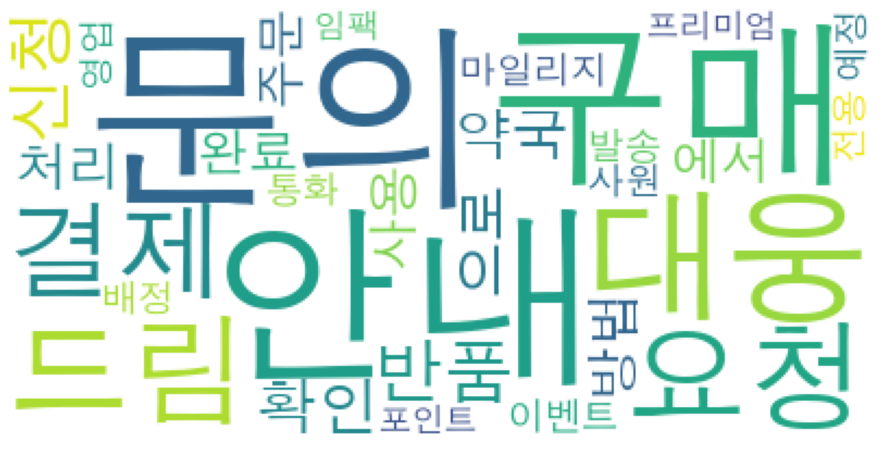

In [24]:
# 토픽 개수, 키워드 개수를 정해주는 변수를 추가.
NUM_TOPICS = 2

NUM_TOPIC_WORDS = 30


def build_doc_term_mat(documents):
    # 문서-단어 행렬 만들어주는 함수.
    print("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]
        
    return corpus, dictionary


def print_topic_words(model):

    # 토픽 모델링 결과를 출력해 주는 함수.
    print("\nPrinting topic words.\n")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))
        
        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))
            
        print("\n")

def word_cloud(model):
    for topic_id in range(model.num_topics):
        wordcloud = WordCloud(font_path='/Library/Fonts/AppleGothic.ttf',
                          relative_scaling = 0.2,
                          #stopwords=STOPWORDS,
                          background_color='white',
                          ).generate_from_frequencies(dict(model.show_topic(topic_id,NUM_TOPIC_WORDS)))
        plt.figure(figsize=(16,8))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        print("\n\n")
        
        
# document-term matrix를 만들고,
corpus, dictionary = build_doc_term_mat(gensim_corpus)
# LDA를 실행.
model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary)
# 결과를 출력.
print_topic_words(model)
#워드 클라우드 출력
word_cloud(model)

In [25]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim as gensimvis

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = gensimvis.prepare(model, corpus, model.id2word)
pyLDAvis.display(data)

# 월별 문의사항 데이터 KR-wordrank 분석

참조 사이트: https://pypi.org/project/krwordrank/

In [26]:
from krwordrank.word import KRWordRank

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
min_count = 5   # 단어의 최소 출현 빈도수 (그래프 생성 시)
max_length = 10 # 단어의 최대 길이
wordrank_extractor = KRWordRank(min_count=min_count, max_length=max_length)

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
beta = 0.85    # PageRank의 decaying factor beta
max_iter = 10
texts = tfidf_corpus #1차원인 list가 필요해 tfidf에서 쓰인 corpus를 그대로 사용함.
keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter)

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
        print('%8s:\t%.4f' % (word, r))

      플러:	2.7769
     마일리:	2.7054
      이벤:	2.5283
      포인:	2.4820
      담당:	2.2132
      주문:	1.5727
      이마:	1.5708
      바이:	1.5707
      제이:	1.5478
      예치:	1.5256
      국민:	1.4880
      어려:	1.4270
      전용:	1.3967
     스트로:	1.3859
      프로:	1.3499
      신용:	1.2902
      상품:	1.2789
      나이:	1.2669
      연락:	1.2028
      마이:	1.1553
      된다:	1.1308
      메디:	1.0780
      계산:	1.0664
      종이:	1.0651
     프리미:	1.0367
      판촉:	1.0312
      스위:	1.0000
      현금:	1.0000
      카라:	1.0000
      장바:	1.0000


/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
SW

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'가\n',
 '가까스로\n',
 '가령\n',
 '각\n',
 '각각\n',
 '각자\n',
 '각종\n',
 '갖고말하자면\n',
 '같다\n',
 '같이\n',
 '개의치않고\n',
 '거니와\n',
 '거바\n',
 '거의\n',
 '것\n',
 '것과 같이\n',
 '것들\n',
 '게다가\n',
 '게우다\n',
 '겨우\n',
 '견지에서\n',
 '결과에 이르다\n',
 '결국\n',
 '결론을 낼 수 있다\n',
 '겸사겸사\n',
 '고려하면\n',
 '고로\n',
 '곧\n',
 '공동으로\n',
 '과\n',
 '과연\n',
 '관계가 있다\n',
 '관계없이\n',
 '관련이 있다\n',
 '관하여\n',
 '관한\n',
 '관해서는\n',
 '구\n',
 '구체적으로\n',
 '구토하다\n',
 '그\n',
 '그들\n',
 '그때\n',
 '그래\n',
 '그래도\n',
 '그래서\n',
 '그러나\n',
 '그러니\n',
 '그러니까\n',
 '그러면\n',
 '그러므로\n',
 '그러한즉\n',
 '그런 까닭에\n',
 '그런데\n',
 '그런즉\n',
 '그럼\n',
 '그럼에도 불구하고\n',
 '그렇게 함으로써\n',
 '그렇지\n',
 '그렇지 않다면\n',
 '그렇지 않으면\n',
 '그렇지만\n',
 '그렇지않으면\n',
 '그리고\n',
 '그리하여\n',
 '그만이다\n',
 '그에 따르는\n',
 '그위에\n',
 '그저\n',
 '그중에서\n',
 '그치지 않다\n',
 '근거로\n',
 '근거하여\n',
 '기대여\n',
 '기점으로\n',
 '기준으로\n',
 '기타\n',
 '까닭으로\n',
 '까악\n',
 '까지\n',
 '까지 미치다\n',
 '까지도\n',
 '꽈당\n',
 '끙끙\n',
 '끼익\n',
 '나\n',
 '나머지는\n',
 '남들\n',
 '남짓\n',
 '너\n',
 '너희\n',
 '너희들\n',
 '네\n',
 '넷\n',
 '년\n',
 '논하지 않다\n',
 '놀라다\n',

In [31]:
stopwords = SW
passwords = {word:score for word, score in sorted(
    keywords.items(), key=lambda x:-x[1])[:300] if not (word in stopwords)}

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
krwordrank_cloud = WordCloud(
    font_path = '/Library/Fonts/AppleGothic.ttf',
    width = 800,
    height = 800,
    background_color="white"
)
krwordrank_cloud = krwordrank_cloud.generate_from_frequencies(passwords)

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(krwordrank_cloud, interpolation="bilinear")
plt.show()

/Users/hyunkyungwoo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
fig.savefig('./lalaland_wordcloud.png') #그림 저장